In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

import scipy.stats
import scipy.optimize
from scipy.signal import find_peaks

%pylab inline

from lmfit import minimize, Parameters, Model, fit_report

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(sc.__version__)

1.1.0


In [3]:
def gauss(x, mu, sigma, k):
    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def line(x, a, b):
    return a*x+b

def breit_vigner2(x, M, w = 11.3, alpha = 0.018):
    G = alpha * (w ** 2) + 1
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner4(x, M, w,  G1):
    a = M/(2*np.pi*G1)
    b = 1 + np.square(2*(x-w)/G1)
    return np.round(a/b, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

In [4]:
def QFC_back(E, E_qf, N_0, W = 22, T = 100):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    x = E_t_gs - E
    return N_0 * ( 1 - np.exp((x-E_0)/T) )/( 1 + ((x-E_qf)/W)**2)

def QFC_back2(x, E_qf, N_0, W, T):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    E = E_t_gs - x
    return N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)

def QFC_back3(x, E_qf, N_0, W, T):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

def QFC_back4(x, E_qf, N_0):
    W = 200
    T = 100
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

In [5]:
data_to_fit_x = np.linspace(0,28, 4000)

In [6]:
def prepare_data(x_data_out, dataframe0_4, dataframeIAS, dataframe4_28, noIAS=False, distance=60):
    if noIAS == False:
        beginning = dataframe4_28[((dataframe4_28['x']<8.1))]
        middle = dataframeIAS[((dataframeIAS['x']>8.1) & (dataframeIAS['x']<8.65))]
        ending = dataframe4_28[((dataframe4_28['x']>8.65))]
        data = dataframe0_4.append(beginning).append(middle).append(ending)
    else: 
        data = dataframe0_4.append(dataframe4_28)
    
    x_data = np.linspace(0,28,len(data['x'].values))
    y_data = np.interp(x_data, data['x'].values, data['y'].values)
    
    peaks, _ = sc.signal.find_peaks(-y_data+30, distance=distance)
    
    #y_data2 doesn't contain IAS
    y_data2 = np.interp(x_data, x_data[peaks], y_data[peaks])
    
    #temp1 - raw data, temp2 - smothed data with no IAS
    temp1 = pd.DataFrame({'x':x_data, 'y':y_data})
    temp2 = pd.DataFrame({'x':x_data, 'y':y_data2})
    
    #data3 - smothed data with IAS
    data3 = temp2[(temp2['x']<8.1)].append(temp1[((temp1['x']>8.17) & (temp1['x']<8.65))]).append(temp2[(temp2['x']>8.65)])
    
    y_data_out = np.interp(x_data_out, data3['x'].values, data3['y'].values)
    return temp1, y_data_out

### red

(0, 10)

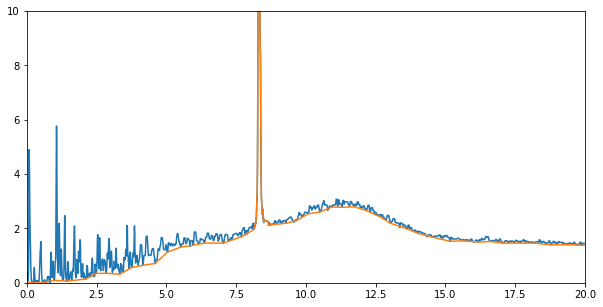

In [7]:
red_0_4 = pd.read_csv('../B(GT) peaks processing/recognition/red data/0_4_red.csv', 
                      sep='\t', decimal=',')
redIAS = pd.read_csv('../B(GT) peaks processing/recognition/red data/IAS_red.csv', 
                      sep='\t', decimal=',')
red_4_28 = pd.read_csv('../B(GT) peaks processing/recognition/red data/4_28_red.csv', 
                      sep='\t', decimal=',')

red_full, red_smothed = prepare_data(data_to_fit_x, red_0_4, redIAS, red_4_28)

plt.figure(figsize=(10,5))
plt.plot(red_full['x'].values, red_full['y'].values)
plt.plot(data_to_fit_x, red_smothed)
plt.xlim(0,20)
plt.ylim(0,10)

### violet

(0, 5)

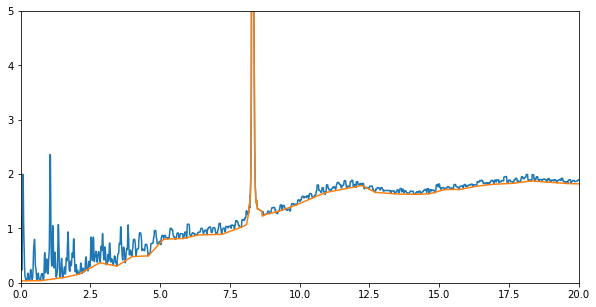

In [8]:
violet_0_4 = pd.read_csv('../B(GT) peaks processing/recognition/violet/0-4.csv', 
                         sep=';', decimal=',', names=['x','y'], header=None)
violetIAS = pd.read_csv('../B(GT) peaks processing/recognition/violet/IAS.csv', 
                         sep=';', decimal=',', names=['x','y'], header=None)
violet_4_28 = pd.read_csv('../B(GT) peaks processing/recognition/violet/4-28.csv', 
                         sep=';', decimal=',', names=['x','y'], header=None)

violet_full, violet_smothed = prepare_data(data_to_fit_x, violet_0_4, violetIAS, 
                                           violet_4_28)

plt.figure(figsize=(10,5))
plt.plot(violet_full['x'].values, violet_full['y'].values)
plt.plot(data_to_fit_x, violet_smothed)
plt.xlim(0,20)
plt.ylim(0,5)

### blue

(0, 5)

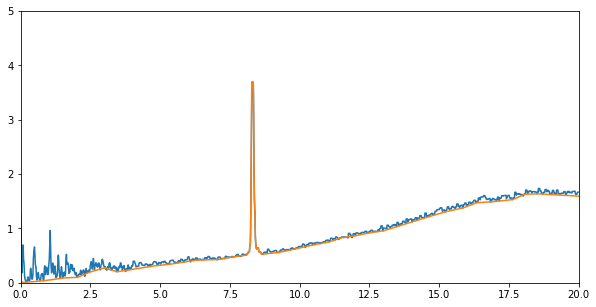

In [9]:
blue_0_4 = pd.read_csv('../B(GT) peaks processing/recognition/blue_data/0-4.csv', 
                         sep=';', decimal=',', names=['x','y'], header=None)
blue_4_28 = pd.read_csv('../B(GT) peaks processing/recognition/blue_data/4-28.csv', 
                         sep=';', decimal=',', names=['x','y'], header=None)

blue_full, blue_smothed = prepare_data(data_to_fit_x, blue_0_4, blue_4_28, 
                                       blue_4_28, noIAS=True)

plt.figure(figsize=(10,5))
plt.plot(blue_full['x'].values, blue_full['y'].values)
plt.plot(data_to_fit_x, blue_smothed)
plt.xlim(0,20)
plt.ylim(0,5)

https://stackoverflow.com/questions/20339234/python-and-lmfit-how-to-fit-multiple-datasets-with-shared-parameters

https://groups.google.com/forum/#!topic/lmfit-py/orAT3mJJdL4

In [10]:

data_to_fit_y = np.array([red_smothed, violet_smothed, blue_smothed])

data_to_fit_x.shape, data_to_fit_y.shape

((4000,), (3, 4000))

In [11]:
def total_dataset(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_w = params['PR1_w_%i' % (i+1)].value
    PR1_G1 = params['PR1_G1_%i' % (i+1)].value
    PR1_M = params['PR1_M_%i' % (i+1)].value
    
    IAS1_w = params['IAS1_w_%i' % (i+1)].value
    IAS1_G1 = params['IAS1_G1_%i' % (i+1)].value
    IAS1_M = params['IAS1_M_%i' % (i+1)].value
    
    IAS2_w = params['IAS2_w_%i' % (i+1)].value
    IAS2_G1 = params['IAS2_G1_%i' % (i+1)].value
    IAS2_M = params['IAS2_M_%i' % (i+1)].value
    
    GTR_w = params['GTR_w_%i' % (i+1)].value
    GTR_G1 = params['GTR_G1_%i' % (i+1)].value
    GTR_M = params['GTR_M_%i' % (i+1)].value
    
    SDR_w = params['SDR_w_%i' % (i+1)].value
    SDR_G1 = params['SDR_G1_%i' % (i+1)].value
    SDR_M = params['SDR_M_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    out = breit_vigner3(x, PR1_M, PR1_w, PR1_G1)\
    + breit_vigner3(x, IAS1_M, IAS1_w, IAS1_G1)\
    + breit_vigner3(x, IAS2_M, IAS2_w, IAS2_G1)\
    + breit_vigner3(x, GTR_M, GTR_w, GTR_G1)\
    + breit_vigner3(x, SDR_M, SDR_w, SDR_G1)\
    + QFC_back4(x, QFC_Eqf, QFC_N0)
    
    return out

def total_dataset3PR(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_w = params['PR1_w_%i' % (i+1)].value
    PR1_G1 = params['PR1_G1_%i' % (i+1)].value
    PR1_M = params['PR1_M_%i' % (i+1)].value
    
    PR2_w = params['PR2_w_%i' % (i+1)].value
    PR2_G1 = params['PR2_G1_%i' % (i+1)].value
    PR2_M = params['PR2_M_%i' % (i+1)].value
    
    PR3_w = params['PR3_w_%i' % (i+1)].value
    PR3_G1 = params['PR3_G1_%i' % (i+1)].value
    PR3_M = params['PR3_M_%i' % (i+1)].value
    
    IAS1_w = params['IAS1_w_%i' % (i+1)].value
    IAS1_G1 = params['IAS1_G1_%i' % (i+1)].value
    IAS1_M = params['IAS1_M_%i' % (i+1)].value
    
    IAS2_w = params['IAS2_w_%i' % (i+1)].value
    IAS2_G1 = params['IAS2_G1_%i' % (i+1)].value
    IAS2_M = params['IAS2_M_%i' % (i+1)].value
    
    GTR_w = params['GTR_w_%i' % (i+1)].value
    GTR_G1 = params['GTR_G1_%i' % (i+1)].value
    GTR_M = params['GTR_M_%i' % (i+1)].value
    
    SDR_w = params['SDR_w_%i' % (i+1)].value
    SDR_G1 = params['SDR_G1_%i' % (i+1)].value
    SDR_M = params['SDR_M_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    out = breit_vigner3(x, PR1_M, PR1_w, PR1_G1)\
    + breit_vigner3(x, PR2_M, PR2_w, PR2_G1)\
    + breit_vigner3(x, PR3_M, PR3_w, PR3_G1)\
    + breit_vigner3(x, IAS1_M, IAS1_w, IAS1_G1)\
    + breit_vigner3(x, IAS2_M, IAS2_w, IAS2_G1)\
    + breit_vigner3(x, GTR_M, GTR_w, GTR_G1)\
    + breit_vigner3(x, SDR_M, SDR_w, SDR_G1)\
    + QFC_back4(x, QFC_Eqf, QFC_N0)
    
    return out

In [12]:
def total_dataset_for_plot(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_w = params['PR1_w_%i' % (i+1)].value
    PR1_G1 = params['PR1_G1_%i' % (i+1)].value
    PR1_M = params['PR1_M_%i' % (i+1)].value
    
    IAS1_w = params['IAS1_w_%i' % (i+1)].value
    IAS1_G1 = params['IAS1_G1_%i' % (i+1)].value
    IAS1_M = params['IAS1_M_%i' % (i+1)].value
    
    IAS2_w = params['IAS2_w_%i' % (i+1)].value
    IAS2_G1 = params['IAS2_G1_%i' % (i+1)].value
    IAS2_M = params['IAS2_M_%i' % (i+1)].value
    
    GTR_w = params['GTR_w_%i' % (i+1)].value
    GTR_G1 = params['GTR_G1_%i' % (i+1)].value
    GTR_M = params['GTR_M_%i' % (i+1)].value
    
    SDR_w = params['SDR_w_%i' % (i+1)].value
    SDR_G1 = params['SDR_G1_%i' % (i+1)].value
    SDR_M = params['SDR_M_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    PR1 = breit_vigner3(x, PR1_M, PR1_w, PR1_G1)
    IAS1 = breit_vigner3(x, IAS1_M, IAS1_w, IAS1_G1)
    IAS2 = breit_vigner3(x, IAS2_M, IAS2_w, IAS2_G1)
    GTR = breit_vigner3(x, GTR_M, GTR_w, GTR_G1)
    SDR = breit_vigner3(x, SDR_M, SDR_w, SDR_G1)
    QFC = QFC_back4(x, QFC_Eqf, QFC_N0)
    
    return PR1, IAS1, IAS2, GTR, SDR, QFC


def total_dataset_for_plot3PR(params, i, x):
    """calc data from params for data set i
    using simple, hardwired naming convention"""
    
    PR1_w = params['PR1_w_%i' % (i+1)].value
    PR1_G1 = params['PR1_G1_%i' % (i+1)].value
    PR1_M = params['PR1_M_%i' % (i+1)].value
    
    PR2_w = params['PR2_w_%i' % (i+1)].value
    PR2_G1 = params['PR2_G1_%i' % (i+1)].value
    PR2_M = params['PR2_M_%i' % (i+1)].value
    
    PR3_w = params['PR3_w_%i' % (i+1)].value
    PR3_G1 = params['PR3_G1_%i' % (i+1)].value
    PR3_M = params['PR3_M_%i' % (i+1)].value
    
    IAS1_w = params['IAS1_w_%i' % (i+1)].value
    IAS1_G1 = params['IAS1_G1_%i' % (i+1)].value
    IAS1_M = params['IAS1_M_%i' % (i+1)].value
    
    IAS2_w = params['IAS2_w_%i' % (i+1)].value
    IAS2_G1 = params['IAS2_G1_%i' % (i+1)].value
    IAS2_M = params['IAS2_M_%i' % (i+1)].value
    
    GTR_w = params['GTR_w_%i' % (i+1)].value
    GTR_G1 = params['GTR_G1_%i' % (i+1)].value
    GTR_M = params['GTR_M_%i' % (i+1)].value
    
    SDR_w = params['SDR_w_%i' % (i+1)].value
    SDR_G1 = params['SDR_G1_%i' % (i+1)].value
    SDR_M = params['SDR_M_%i' % (i+1)].value
    
    QFC_Eqf = params['QFC_Eqf_%i' % (i+1)].value
    QFC_N0 = params['QFC_N0_%i' % (i+1)].value
    
    PR1 = breit_vigner3(x, PR1_M, PR1_w, PR1_G1)
    PR2 = breit_vigner3(x, PR2_M, PR2_w, PR2_G1)
    PR3 = breit_vigner3(x, PR3_M, PR3_w, PR3_G1)
    IAS1 = breit_vigner3(x, IAS1_M, IAS1_w, IAS1_G1)
    IAS2 = breit_vigner3(x, IAS2_M, IAS2_w, IAS2_G1)
    GTR = breit_vigner3(x, GTR_M, GTR_w, GTR_G1)
    SDR = breit_vigner3(x, SDR_M, SDR_w, SDR_G1)
    QFC = QFC_back4(x, QFC_Eqf, QFC_N0)
    
    return PR1, PR2, PR3, IAS1, IAS2, GTR, SDR, QFC

In [13]:
def objective(params, x, data):
    """ calculate total residual for fits to several data sets held
    in a 2-D array, and modeled by our functions"""
    ndata, nx = data.shape
    resid = 0.0*data[:]
    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - total_dataset(params, i, x)
    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

def objective3PR(params, x, data):
    """ calculate total residual for fits to several data sets held
    in a 2-D array, and modeled by our functions"""
    ndata, nx = data.shape
    resid = 0.0*data[:]
    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - total_dataset3PR(params, i, x)
    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

In [23]:
fit_params = Parameters()
for iy, y in enumerate(data_to_fit_y):
    fit_params.add( 'PR1_w_%i' % (iy+1), value=6, min=5, max=7)
    fit_params.add( 'PR1_G1_%i' % (iy+1), value=0.1, min=0.1, max=2)
    fit_params.add( 'PR1_M_%i' % (iy+1), value=0.5, min=0.1, max= 5)
    
    fit_params.add( 'IAS1_w_%i' % (iy+1), value=8.308, vary=False)
    fit_params.add( 'IAS1_G1_%i' % (iy+1), value=0.01, min=0.01, max=0.02)
    fit_params.add( 'IAS1_M_%i' % (iy+1), value=0.5, min=0.05, max=0.7)
    
    fit_params.add( 'IAS2_w_%i' % (iy+1), value=8.360, vary=False)
    fit_params.add( 'IAS2_G1_%i' % (iy+1), value=0.03, min=0.01, max=0.05)
    fit_params.add( 'IAS2_M_%i' % (iy+1), value=0.1, min=0.01, max=0.5)

    fit_params.add( 'GTR_w_%i' % (iy+1), value=11.0, min=11, max=11.5)
    fit_params.add( 'GTR_G1_%i' % (iy+1), value=2, min=2, max=4)
    fit_params.add( 'GTR_M_%i' % (iy+1), value=0.5, min=0.1, max= 15)
    
    fit_params.add( 'SDR_w_%i' % (iy+1), value=18.5, min=18, max=19)
    fit_params.add( 'SDR_G1_%i' % (iy+1), value=0.01, min=0.1, max=10)
    fit_params.add( 'SDR_M_%i' % (iy+1), value=0.5, min=0.1, max= 5)
    
    fit_params.add( 'QFC_Eqf_%i' % (iy+1), value=400, max=410, min=385 )
    fit_params.add( 'QFC_N0_%i' % (iy+1), value=8, max=15, min=1 )
    
# but now constrain all values of sigma to have the same value
# by assigning sig_2, sig_3, .. sig_5 to be equal to sig_1
for iy in (2, 3):
    fit_params['PR1_w_%i' % iy].expr='PR1_w_1'
    fit_params['PR1_G1_%i' % iy].expr='PR1_G1_1'
    
    fit_params['IAS1_G1_%i' % iy].expr='IAS1_G1_1'
    fit_params['IAS2_G1_%i' % iy].expr='IAS2_G1_1'
    
    fit_params['GTR_w_%i' % iy].expr='GTR_w_1'
    fit_params['GTR_G1_%i' % iy].expr='GTR_G1_1'
    
    fit_params['SDR_w_%i' % iy].expr='SDR_w_1'
    fit_params['SDR_G1_%i' % iy].expr='SDR_G1_1'
    
    fit_params['QFC_Eqf_%i' % iy].expr='QFC_Eqf_1'

In [24]:
#fit_params

In [25]:
result = minimize(objective, fit_params, args=(data_to_fit_x, data_to_fit_y), 
                  method='differential_evolution')

In [26]:
#print(fit_report(result))

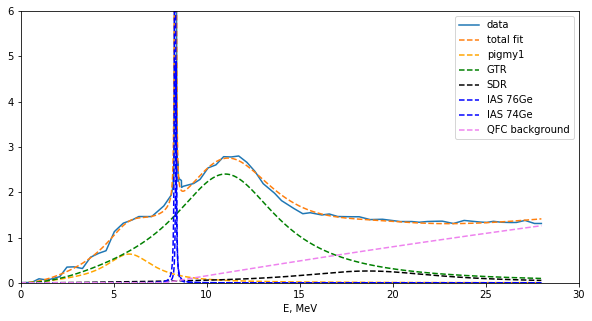

In [27]:
i = 0
plt.figure(figsize=(10,5))
y_fit = total_dataset(result.params, i, data_to_fit_x)
plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, IAS1, IAS2, GTR, SDR, QFC = total_dataset_for_plot(result.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS 76Ge')
plt.plot(data_to_fit_x, IAS2, 'b--', label='IAS 74Ge')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')

plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)
plt.xlim(0,30)
plt.legend()
plt.show()

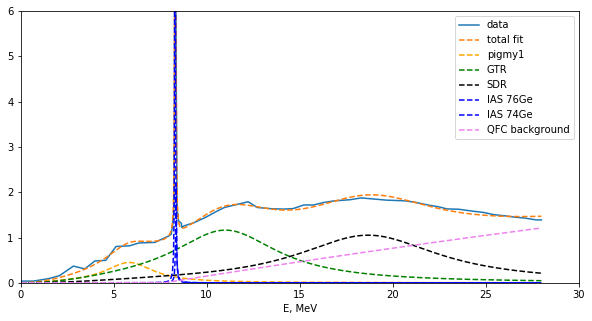

In [28]:
i = 1
plt.figure(figsize=(10,5))
y_fit = total_dataset(result.params, i, data_to_fit_x)
plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, IAS1, IAS2, GTR, SDR, QFC = total_dataset_for_plot(result.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS 76Ge')
plt.plot(data_to_fit_x, IAS2, 'b--', label='IAS 74Ge')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')

plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)
plt.xlim(0,30)
plt.legend()
plt.show()

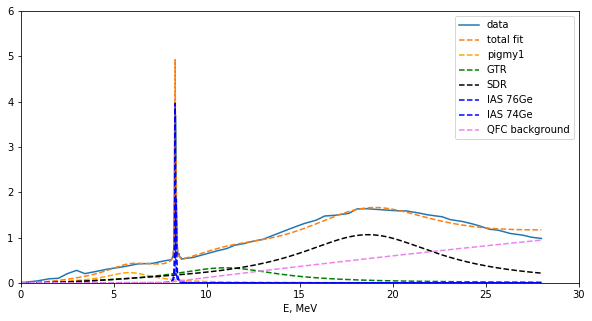

In [29]:
i = 2
plt.figure(figsize=(10,5))
y_fit = total_dataset(result.params, i, data_to_fit_x)
plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, IAS1, IAS2, GTR, SDR, QFC = total_dataset_for_plot(result.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS 76Ge')
plt.plot(data_to_fit_x, IAS2, 'b--', label='IAS 74Ge')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')

plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)
plt.xlim(0,30)
plt.legend()
plt.show()

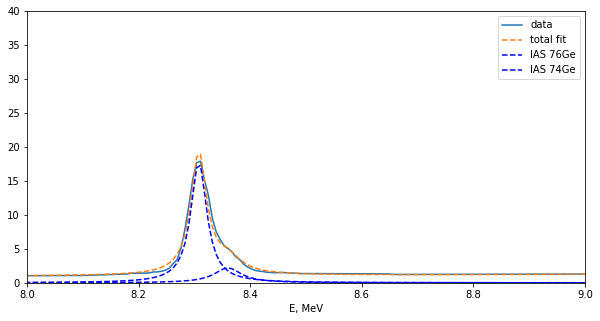

In [30]:
i = 1
plt.figure(figsize=(10,5))
y_fit = total_dataset(result.params, i, data_to_fit_x)
plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, IAS1, IAS2, GTR, SDR, QFC = total_dataset_for_plot(result.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS 76Ge')
plt.plot(data_to_fit_x, IAS2, 'b--', label='IAS 74Ge')

plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,40)
plt.xlim(8,9)
plt.legend()
plt.show()

In [31]:
result.params.pretty_print(columns=['value', 'min', 'max', 'vary', 'expr'])

Name          Value      Min      Max     Vary     Expr
GTR_G1_1      3.465        2        4     True     None
GTR_G1_2      3.465        2        4    False GTR_G1_1
GTR_G1_3      3.465        2        4    False GTR_G1_1
GTR_M_1       8.318      0.1       15     True     None
GTR_M_2       4.028      0.1       15     True     None
GTR_M_3       1.146      0.1       15     True     None
GTR_w_1       11.01       11     11.5     True     None
GTR_w_2       11.01       11     11.5    False  GTR_w_1
GTR_w_3       11.01       11     11.5    False  GTR_w_1
IAS1_G1_1   0.01725     0.01     0.02     True     None
IAS1_G1_2   0.01725     0.01     0.02    False IAS1_G1_1
IAS1_G1_3   0.01725     0.01     0.02    False IAS1_G1_1
IAS1_M_1     0.5771     0.05      0.7     True     None
IAS1_M_2     0.3074     0.05      0.7     True     None
IAS1_M_3    0.07049     0.05      0.7     True     None
IAS1_w_1      8.308     -inf      inf    False     None
IAS1_w_2      8.308     -inf      inf    False

In [80]:
result.params.valuesdict()

OrderedDict([('PR1_w_1', 5.557072282656855),
             ('PR1_G1_1', 1.9999666045383466),
             ('PR1_M_1', 1.3449342451334203),
             ('IAS_w_1', 8.308),
             ('IAS_G1_1', 0.019998010654042053),
             ('IAS_M_1', 0.6815354702573952),
             ('GTR_w_1', 11.030599412878095),
             ('GTR_G1_1', 3.7393967760598583),
             ('GTR_M_1', 8.720339111220541),
             ('SDR_w_1', 18.993917456960553),
             ('SDR_G1_1', 6.501487976719543),
             ('SDR_M_1', 0.6330151100248046),
             ('QFC_Eqf_1', 397.3766659041863),
             ('QFC_N0_1', 7.257720760760778),
             ('PR1_w_2', 5.557072282656855),
             ('PR1_G1_2', 1.9999666045383466),
             ('PR1_M_2', 0.5349975883731266),
             ('IAS_w_2', 8.308),
             ('IAS_G1_2', 0.019998010654042053),
             ('IAS_M_2', 0.5009260159893213),
             ('GTR_w_2', 11.030599412878095),
             ('GTR_G1_2', 3.7393967760598583),
      

In [90]:
result.params.valuesdict()['QFC_N0_3']

5.435928434987305

In [50]:
fit_params3PR = Parameters()
for iy, y in enumerate(data_to_fit_y):
    fit_params3PR.add( 'PR1_w_%i' % (iy+1), value=2, min=1, max=4)
    fit_params3PR.add( 'PR1_G1_%i' % (iy+1), value=0.1, min=0.1, max=0.6)
    fit_params3PR.add( 'PR1_M_%i' % (iy+1), value=0.1, min=0.01, max=0.4)
    
    fit_params3PR.add( 'PR2_w_%i' % (iy+1), value=3, min=2, max=6)
    fit_params3PR.add( 'PR2_G1_%i' % (iy+1), value=0.1, min=0.1, max=1)
    fit_params3PR.add( 'PR2_M_%i' % (iy+1), value=0.1, min=0.01, max=0.6)
    
    fit_params3PR.add( 'PR3_w_%i' % (iy+1), value=6, min=5, max=7)
    fit_params3PR.add( 'PR3_G1_%i' % (iy+1), value=0.1, min=0.1, max=1)
    fit_params3PR.add( 'PR3_M_%i' % (iy+1), value=0.1, min=0.01, max=0.8)
    
    fit_params3PR.add( 'IAS1_w_%i' % (iy+1), value=8.308, vary=False)
    fit_params3PR.add( 'IAS1_G1_%i' % (iy+1), value=0.01, min=0.01, max=0.02)
    fit_params3PR.add( 'IAS1_M_%i' % (iy+1), value=0.5, min=0.05, max=0.7)
    
    fit_params3PR.add( 'IAS2_w_%i' % (iy+1), value=8.360, vary=False)
    fit_params3PR.add( 'IAS2_G1_%i' % (iy+1), value=0.03, min=0.01, max=0.05)
    fit_params3PR.add( 'IAS2_M_%i' % (iy+1), value=0.1, min=0.01, max=0.5)

    fit_params3PR.add( 'GTR_w_%i' % (iy+1), value=11.0, min=11, max=11.5)
    fit_params3PR.add( 'GTR_G1_%i' % (iy+1), value=2, min=2, max=4)
    fit_params3PR.add( 'GTR_M_%i' % (iy+1), value=0.5, min=0.1, max= 15)
    
    fit_params3PR.add( 'SDR_w_%i' % (iy+1), value=18.5, min=18, max=19)
    fit_params3PR.add( 'SDR_G1_%i' % (iy+1), value=0.01, min=0.1, max=10)
    fit_params3PR.add( 'SDR_M_%i' % (iy+1), value=0.5, min=0.1, max= 5)
    
    fit_params3PR.add( 'QFC_Eqf_%i' % (iy+1), value=400, max=410, min=300 )
    fit_params3PR.add( 'QFC_N0_%i' % (iy+1), value=8, max=15, min=1 )
    
# but now constrain all values of sigma to have the same value
# by assigning sig_2, sig_3, .. sig_5 to be equal to sig_1
for iy in (2, 3):
    fit_params3PR['PR1_w_%i' % iy].expr='PR1_w_1'
    fit_params3PR['PR1_G1_%i' % iy].expr='PR1_G1_1'
    
    fit_params3PR['PR2_w_%i' % iy].expr='PR2_w_1'
    fit_params3PR['PR2_G1_%i' % iy].expr='PR2_G1_1'
    
    fit_params3PR['PR3_w_%i' % iy].expr='PR3_w_1'
    fit_params3PR['PR3_G1_%i' % iy].expr='PR3_G1_1'
    
    fit_params3PR['IAS1_G1_%i' % iy].expr='IAS1_G1_1'
    fit_params3PR['IAS2_G1_%i' % iy].expr='IAS2_G1_1'
    
    fit_params3PR['GTR_w_%i' % iy].expr='GTR_w_1'
    fit_params3PR['GTR_G1_%i' % iy].expr='GTR_G1_1'
    
    fit_params3PR['SDR_w_%i' % iy].expr='SDR_w_1'
    fit_params3PR['SDR_G1_%i' % iy].expr='SDR_G1_1'
    
    fit_params3PR['QFC_Eqf_%i' % iy].expr='QFC_Eqf_1'

In [51]:
result3PR = minimize(objective3PR, fit_params3PR, args=(data_to_fit_x, data_to_fit_y), 
                  method='differential_evolution')

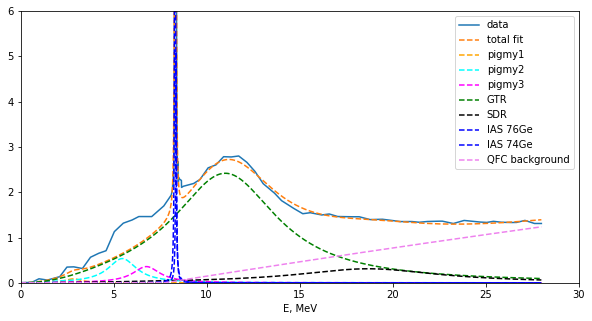

In [53]:
i = 0
plt.figure(figsize=(10,5))
y_fit = total_dataset(result3PR.params, i, data_to_fit_x)
plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, PR2, PR3, IAS1, IAS2, GTR, SDR, QFC =\
total_dataset_for_plot3PR(result3PR.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, PR2, 'cyan', label='pigmy2', ls='--')
plt.plot(data_to_fit_x, PR3, 'magenta', label='pigmy3', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS 76Ge')
plt.plot(data_to_fit_x, IAS2, 'b--', label='IAS 74Ge')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')

plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)
plt.xlim(0,30)
plt.legend()
plt.show()

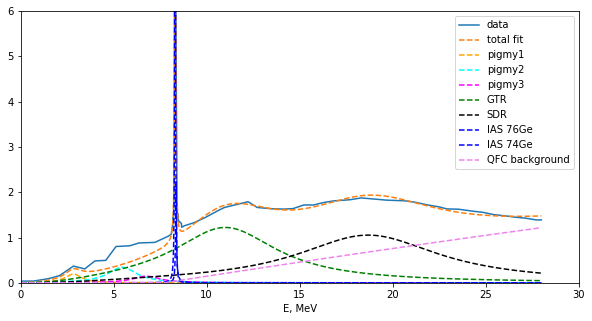

In [54]:
i = 1
plt.figure(figsize=(10,5))
y_fit = total_dataset(result3PR.params, i, data_to_fit_x)
plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, PR2, PR3, IAS1, IAS2, GTR, SDR, QFC =\
total_dataset_for_plot3PR(result3PR.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, PR2, 'cyan', label='pigmy2', ls='--')
plt.plot(data_to_fit_x, PR3, 'magenta', label='pigmy3', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS 76Ge')
plt.plot(data_to_fit_x, IAS2, 'b--', label='IAS 74Ge')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')

plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)
plt.xlim(0,30)
plt.legend()
plt.show()

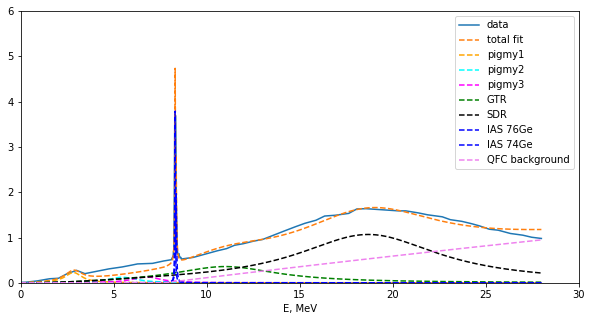

In [55]:
i = 2
plt.figure(figsize=(10,5))
y_fit = total_dataset(result3PR.params, i, data_to_fit_x)
plt.plot(data_to_fit_x, data_to_fit_y[i, :], '-', label='data')
plt.plot(data_to_fit_x, y_fit, '--', label='total fit')

PR1, PR2, PR3, IAS1, IAS2, GTR, SDR, QFC =\
total_dataset_for_plot3PR(result3PR.params, i, data_to_fit_x)

plt.plot(data_to_fit_x, PR1, 'orange', label='pigmy1', ls='--')
plt.plot(data_to_fit_x, PR2, 'cyan', label='pigmy2', ls='--')
plt.plot(data_to_fit_x, PR3, 'magenta', label='pigmy3', ls='--')
plt.plot(data_to_fit_x, GTR, 'g--', label='GTR')
plt.plot(data_to_fit_x, SDR, 'black', label='SDR', ls='--')
plt.plot(data_to_fit_x, IAS1, 'b--', label='IAS 76Ge')
plt.plot(data_to_fit_x, IAS2, 'b--', label='IAS 74Ge')
plt.plot(data_to_fit_x, QFC, 'violet', label='QFC background', ls='--')

plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)
plt.xlim(0,30)
plt.legend()
plt.show()

In [57]:
result3PR.params.pretty_print(columns=['value', 'min', 'max', 'vary', 'expr'])

Name          Value      Min      Max     Vary     Expr
GTR_G1_1      3.417        2        4     True     None
GTR_G1_2      3.417        2        4    False GTR_G1_1
GTR_G1_3      3.417        2        4    False GTR_G1_1
GTR_M_1       8.263      0.1       15     True     None
GTR_M_2       4.175      0.1       15     True     None
GTR_M_3       1.226      0.1       15     True     None
GTR_w_1       11.01       11     11.5     True     None
GTR_w_2       11.01       11     11.5    False  GTR_w_1
GTR_w_3       11.01       11     11.5    False  GTR_w_1
IAS1_G1_1   0.01738     0.01     0.02     True     None
IAS1_G1_2   0.01738     0.01     0.02    False IAS1_G1_1
IAS1_G1_3   0.01738     0.01     0.02    False IAS1_G1_1
IAS1_M_1     0.5782     0.05      0.7     True     None
IAS1_M_2     0.3194     0.05      0.7     True     None
IAS1_M_3    0.06795     0.05      0.7     True     None
IAS1_w_1      8.308     -inf      inf    False     None
IAS1_w_2      8.308     -inf      inf    False